# Mini Lab (20 min) — 2D Discrete Wavelet Transform (DWT): Denoising & Compression

**Audience:** M1 Engineering  
**Goal:** understand multiresolution decomposition (approximation + horizontal/vertical/diagonal details) and use it to **denoise** and **compress** an image.


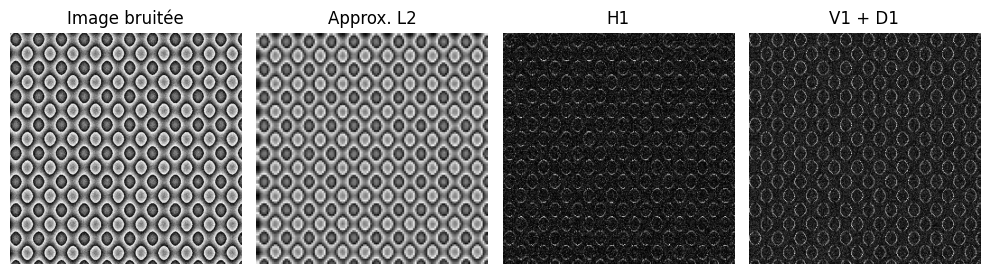

PSNR bruitée :   20.43 dB
PSNR débruitée : 17.27 dB
PSNR compressée (10%): 21.00 dB


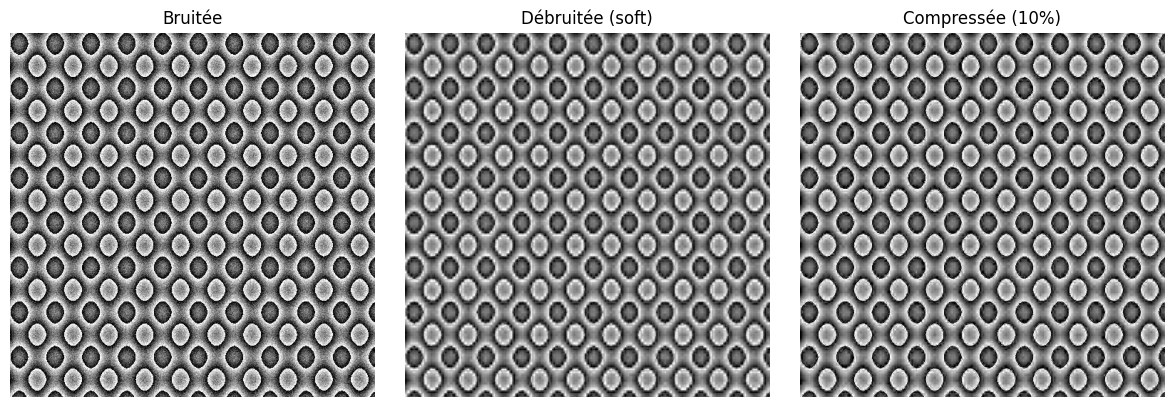

In [5]:
# Pré-requis : pywavelets, scikit-image, matplotlib, pillow
import numpy as np
import pywt, inspect
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.util import random_noise
from PIL import Image
import os

# 1) Image de test + ajout de bruit
if os.path.exists('camera.png'):
    img = img_as_float(np.array(Image.open('camera.png').convert('L')))
else:
    img = img_as_float(data.camera())
bruitee = random_noise(img, mode='gaussian', var=0.01)

# 2) Décomposition en ondelettes 2D (DWT)
ondelette = 'db2'
niveau = 2
coeffs = pywt.wavedec2(bruitee, wavelet=ondelette, level=niveau)
A, details = coeffs[0], coeffs[1:]   # A : approximation, details : [(H,V,D)_L, ..., (H,V,D)_1]

# 3) Visualisation des sous-bandes de niveau 1
(H1, V1, D1) = details[-1]
plt.figure(figsize=(10,3))
plt.subplot(1,4,1); plt.imshow(bruitee, cmap='gray'); plt.title('Image bruitée'); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(A, cmap='gray');       plt.title('Approx. L2'); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(np.abs(H1), cmap='gray'); plt.title('H1'); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(np.abs(V1)+np.abs(D1), cmap='gray'); plt.title('V1 + D1'); plt.axis('off')
plt.tight_layout(); plt.show()

# 4) Dénoyautage par seuillage doux (soft-thresholding)
sigma = np.median(np.abs(D1)) / 0.6745
N = bruitee.size
T = sigma * np.sqrt(2*np.log(N))

def seuillage_doux(coeffs, T):
    cA = coeffs[0]
    nouveaux_details = []
    for (cH, cV, cD) in coeffs[1:]:
        nouveaux_details.append((
            pywt.threshold(cH, T, mode='soft'),
            pywt.threshold(cV, T, mode='soft'),
            pywt.threshold(cD, T, mode='soft'),
        ))
    return [cA] + nouveaux_details

coeffs_denoises = seuillage_doux(coeffs, T)
denoisee = pywt.waverec2(coeffs_denoises, wavelet=ondelette)
denoisee = np.clip(denoisee, 0, 1)

# 5) Compression : conservation des k% plus grands coefficients
k_pourcent = 10  # on garde les 5% plus grands coefficients

def coeffs_vers_array_compat(coeffs):
    if 'output_format' in inspect.signature(pywt.coeffs_to_array).parameters:
        return pywt.coeffs_to_array(coeffs, padding=None, output_format='wavedec2')
    return pywt.coeffs_to_array(coeffs)

def array_vers_coeffs_compat(arr, slices):
    try:
        return pywt.array_to_coeffs(arr, slices, output_format='wavedec2')
    except TypeError:
        return pywt.array_to_coeffs(arr, slices)

arr, slices = coeffs_vers_array_compat(coeffs)
plat = arr.ravel()
k = max(1, int(np.ceil(len(plat) * (k_pourcent / 100.0))))
idx = np.argpartition(np.abs(plat), -k)[-k:]
masque = np.zeros_like(plat, dtype=bool); masque[idx] = True
arr_comp = np.where(masque.reshape(arr.shape), arr, 0.0)

coeffs_comp = array_vers_coeffs_compat(arr_comp, slices)
reconstruit_comp = pywt.waverec2(coeffs_comp, wavelet=ondelette)
reconstruit_comp = np.clip(reconstruit_comp, 0, 1)

# 6) PSNR + affichage des résultats
def psnr(x, y):
    mse = np.mean((x - y)**2)
    return 99. if mse == 0 else 10*np.log10(1.0/mse)

print(f"PSNR bruitée :   {psnr(img, bruitee):.2f} dB")
print(f"PSNR débruitée : {psnr(img, denoisee):.2f} dB")
print(f"PSNR compressée ({k_pourcent}%): {psnr(img, reconstruit_comp):.2f} dB")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(bruitee, cmap='gray');       plt.title('Bruitée'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(denoisee, cmap='gray');      plt.title('Débruitée (soft)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(reconstruit_comp, cmap='gray'); plt.title(f'Compressée ({k_pourcent}%)'); plt.axis('off')
plt.tight_layout(); plt.show()


### Quick variants (if time allows)
- Change `wavelet`: `'haar'`, `'db4'`, `'sym4'`, `'coif1'`…  
- Try `level = 1` vs `3`.  
- Compare **soft** vs **hard** thresholding (artifacts vs smoothing).

## Questions (5 min)
1. What do \(H_1, V_1, D_1\) capture (links to horizontal/vertical/diagonal edges)?  
Answer: H1 represent vertical edge, V1 horizontal edge and D1 represent diagonal edge.
2. How does denoising change when you increase/decrease the **threshold T**?  
Answer: If the threshold is low we have more noise. If the threshold is high we avec less noise but the details are not sharp.
3. Up to which **k%** of kept coefficients is quality acceptable?  
Answer: 
4. Why do some wavelets (e.g., `db4`) produce fewer “staircase” artifacts than `haar`?
